# Demo for using Neural Circuit Policies based on Liquid Neural Networks

In this tutorial we will build a small NCP model based on the LTC neuron model and train it on some synthetic sinusoidal data.

In [1]:
import numpy as np
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC

## Generating synthetic sinusoidal training data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

N = 48  # Length of the time series

In [4]:
# Input

# Input is sine(t) and cosine(t), output is sine(2t)
# Input feature is a sine and a cosine wave
values = np.linspace(0,3*np.pi, N)
sin_values = np.sin(values)
cos_values = np.cos(values)

data_x = np.stack(
    [sin_values, cos_values], axis=1
)
data_x = np.expand_dims(data_x, axis=0)  # Add batch dimension
data_x = data_x.astype(np.float32) 

# Output
# Target output is a sine with double the frequency of the input signal
values = np.linspace(0, 6*np.pi, N)
data_y = np.sin(values).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


In [17]:
# Learning a straight line
values = np.linspace(0,10,N)
y1 = 0.5*values
y2 = 1.5*values

data_x = np.stack([y1, y2], axis=1)
# print(data_x)
data_x = np.expand_dims(data_x, axis=0)
# print(data_x)

data_x = data_x.astype(np.float32)

data_y = 1*values
data_y = data_y.reshape([1,N,1]).astype(np.float32)
# print(data_y)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


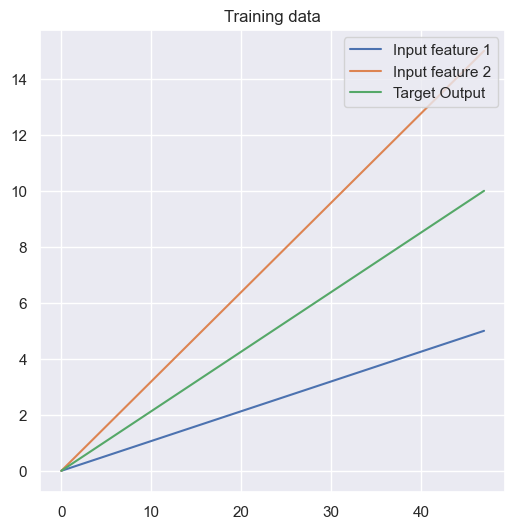

In [6]:
# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 6))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 2")
plt.plot(data_y[0, :, 0], label="Target Output")
# plt.ylim(0,10)
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

## The LTC model with NCP wiring

The `ncps` package is composed of two main parts:
* The LTC models as a `tf.keras.layers.Layer` RNN
* A wiring architecture for the LTC cell above

For wiring we will use `AutoNCP` class, which created an NCP wiring by providing the total number of neurons and the number of outputs (8 and 1 in our case).

Note that as the LTC model is expressed in the form of a system of **ordinary differential equations in time**, any instance of it is inherently a recurrent neural network (RNN). That's is why this simple example considers a sinusoidal time-series.

**(During demonstration take another function and approximate it)**

In [7]:
wiring = wirings.AutoNCP(8,1)  # 8 neurons in total, 1 ouput (motor neuron)
model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None,2)),
        # here we could potentially add layers before and after the LTC network
        LTC(wiring, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), 
    loss='mean_squared_error'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ltc (LTC)                   (None, None, 1)           350       
                                                                 
Total params: 350 (1.37 KB)
Trainable params: 350 (1.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Draw the wiring diagram of the network

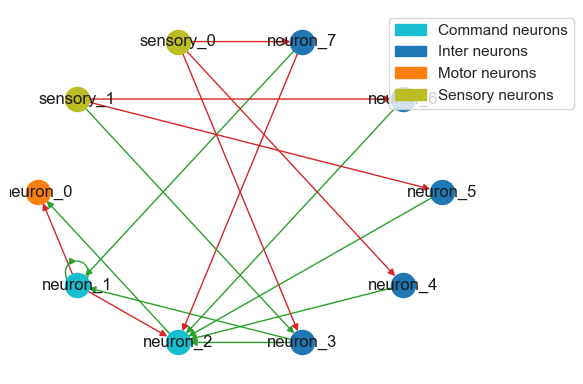

In [8]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(
    draw_labels=True, 
    neuron_colors={"command":"tab:cyan"}
)
plt.legend(
    handles=legend_handles, 
    loc="upper center", 
    bbox_to_anchor=(1,1)
)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

## Visualizing the prediction of the network before training

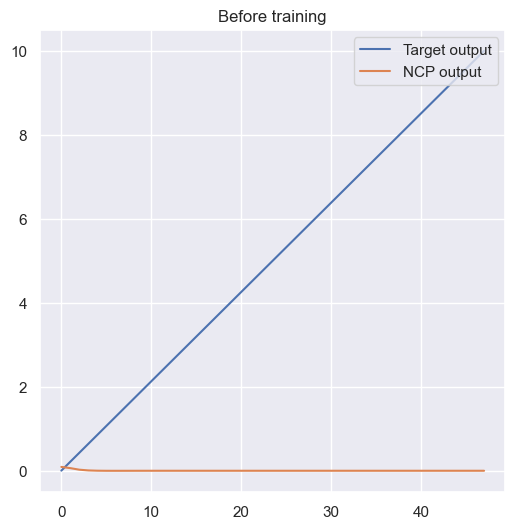

In [9]:
# Let us visualize how out aLTC performs before training
sns.set()
prediction = model(data_x).numpy()

# Plotting
plt.figure(figsize=(6,6))
plt.plot(data_y[0, :, 0], label="Target output")   # Plotting actual output
plt.plot(prediction[0, :, 0], label="NCP output")  # Plotting predictions
# plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

## Training the model

In [10]:
# Train the model for 400 epochs ( =training steps)
hist = model.fit(
    x=data_x,
    y=data_y,
    batch_size=1,
    epochs=400,
    verbose=1
)

Epoch 1/400
1/1 [==============================] - 9s 9s/step - loss: 33.7143
Epoch 2/400
1/1 [==============================] - 0s 62ms/step - loss: 33.3069
Epoch 3/400
1/1 [==============================] - 0s 69ms/step - loss: 32.8934
Epoch 4/400
1/1 [==============================] - 0s 62ms/step - loss: 32.4643
Epoch 5/400
1/1 [==============================] - 0s 68ms/step - loss: 32.0055
Epoch 6/400
1/1 [==============================] - 0s 66ms/step - loss: 31.4956
Epoch 7/400
1/1 [==============================] - 0s 65ms/step - loss: 30.9088
Epoch 8/400
1/1 [==============================] - 0s 64ms/step - loss: 30.2268
Epoch 9/400
1/1 [==============================] - 0s 57ms/step - loss: 29.4575
Epoch 10/400
1/1 [==============================] - 0s 60ms/step - loss: 28.6490
Epoch 11/400
1/1 [==============================] - 0s 56ms/step - loss: 27.8749
Epoch 12/400
1/1 [==============================] - 0s 56ms/step - loss: 27.1869
Epoch 13/400
1/1 [=====================

## Plotting the training loss and the prediction of the model after training

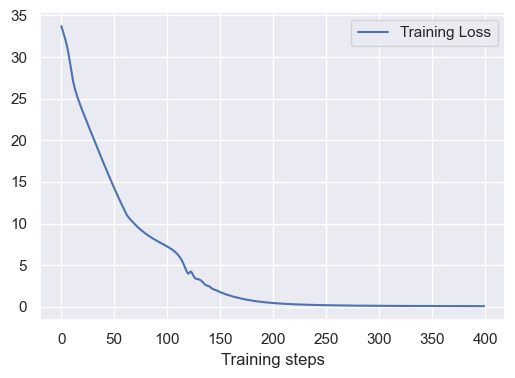

In [11]:
# Let's visualize the training loss
sns.set()
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="Training Loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.show()

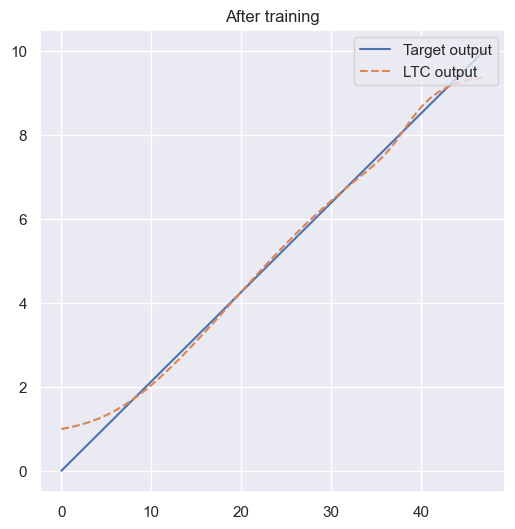

In [12]:
# How does the trained model now fit to the sinusoidal function?
prediction = model(data_x).numpy()
plt.figure(figsize=(6,6))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output", linestyle="dashed")
# plt.ylim((-1,1))
plt.legend(loc="upper right")
plt.title("After training")
plt.show()

In [13]:
val = np.linspace(1*np.pi,2*np.pi, 16)
x1 = np.sin(val)
x2 = np.cos(val)
x = np.stack([x1,x2], axis=1)
x = np.expand_dims(x, axis=0)

y = model(x).numpy()
y=model.predict(x)
# y=model(np.array([[[0.5, 0.154]]]))
print(y)

1/1 [==============================] - 1s 1s/step
[[[0.99441814]
  [1.0368464 ]
  [1.0875403 ]
  [1.1474856 ]
  [1.21761   ]
  [1.2988062 ]
  [1.3918989 ]
  [1.4976032 ]
  [1.6164839 ]
  [1.7489189 ]
  [1.8950608 ]
  [2.0547924 ]
  [2.2276692 ]
  [2.412849  ]
  [2.6091242 ]
  [2.8153718 ]]]


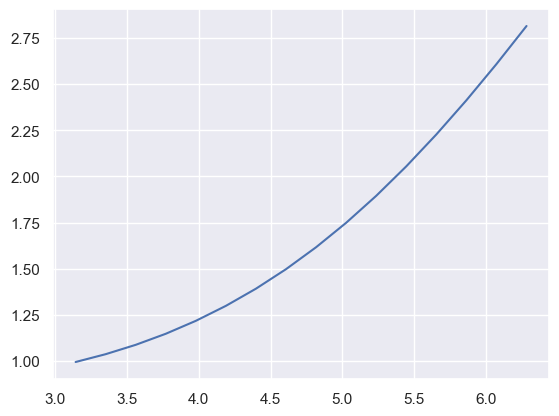

In [14]:
plt.plot(val,y[0,:,0])

TypeError: Wiring.__init__() missing 1 required positional argument: 'units'